In [42]:
import io
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F 
from torch.optim.lr_scheduler import CosineAnnealingLR
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
def set_random_seed(state=1):
    gens = (np.random.seed, torch.manual_seed, torch.cuda.manual_seed)
    for set_state in gens:
        set_state(state)
        
RANDOM_STATE = 1
set_random_seed(RANDOM_STATE)


In [0]:
# заново индексируем по порядку ratings, tg_rel, по имеющимся там фильмам и пользователям  
def indexing(ratings, tg_rel):
    unique_users = ratings.userId.unique()
    user_to_index = {old: new for new, old in enumerate(unique_users)}

    unique_movies = ratings.movieId.unique()
    movie_to_index = {old: new for new, old in enumerate(unique_movies)}
    
    n_users = unique_users.shape[0]
    n_movies = unique_movies.shape[0]
    
    tg_movies = tg_rel['movieId'].map(movie_to_index)
    rat_movies = ratings['movieId'].map(movie_to_index)
    rat_users = ratings['userId'].map(user_to_index)

    ratings = pd.DataFrame({'userId': rat_users, 'movieId': rat_movies, "rating": ratings['rating'].astype(np.float32)})
    tg_rel = pd.DataFrame({'movieId': tg_movies,"tagId": tg_rel['tagId'], "relevance": tg_rel['relevance'].astype(np.float32)})
    return (n_users, n_movies), ratings, tg_rel

In [20]:
# Оставляем в выборке 3000 рандомно выбранных пользователей
rating_films = pd.read_csv(r'ratings.csv')
set_us_id = [*set(rating_films.userId)]
rand_us_id = set(random.sample(set_us_id, 3000))
random_data = rating_films.loc[rating_films.apply(lambda x:x.userId in rand_us_id ,axis = 1)]
# Убираем фильмы, которые были оценены менее 3 раз
rat_val_count = random_data.movieId.value_counts()
ind_rat_cor = rat_val_count[rat_val_count.values>=3].index
ratings = random_data.loc[random_data.apply(lambda x:x.movieId in ind_rat_cor ,axis = 1)]
ratings.to_csv(r"rating_films_corrected1.csv", index = False, header=True)
# Во втором датасете убираем, не оценённые фильмы 
tg_rel = pd.read_csv(r"genome-scores.csv")
movies = set(ratings.movieId.values)
tg_rel= tg_rel.loc[tg_rel.movieId.isin(movies)]
tg_rel.to_csv(r"tags_relevance_corrected1.csv",index = False, header=True)

FileNotFoundError: ignored

In [0]:
ratings = pd.read_csv(r"/content/drive/My Drive/rating_films_corrected1.csv")
tg_rel = pd.read_csv(r"/content/drive/My Drive/tags_relevance_corrected1.csv")

In [0]:
(n_us, n_mov), ratings, tg_rel =  indexing(ratings, tg_rel)

In [0]:
# Класс для того, чтобы из тренировочной выборки брать батчи
class ReviewsIterator:
    
    def __init__(self, X, y, batch_size=32, shuffle=True):
        X, y = np.asarray(X), np.asarray(y)
        
        if shuffle:
            index = np.random.permutation(X.shape[0])
            X, y = X[index], y[index]
            
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_batches = int(math.ceil(X.shape[0] // batch_size))
        self._current = 0
        
    def __iter__(self):
        return self
    
    def __next__(self):
        return self.next()
    
    def next(self):
        if self._current >= self.n_batches:
            raise StopIteration()
        k = self._current
        self._current += 1
        bs = self.batch_size
        return self.X[k*bs:(k + 1)*bs], self.y[k*bs:(k + 1)*bs]

In [0]:
def batches(X, y, bs=32, shuffle=True):
    for xb, yb in ReviewsIterator(X, y, bs, shuffle):
        xb = torch.LongTensor(xb)
        yb = torch.FloatTensor(yb)
        yield xb, yb.view(-1, 1) 

In [0]:
# Класс нейронной сети
class EmbeddingNet(nn.Module):
    """
    n_users:            
      Количество уникальных пользователей

    n_movies: 
      Количество уникальных фильмов

    n_factors: 
      Количество весов в embeddings matrix.

    embedding_dropout: 
      Dropout rate, который делается сразу после embedding layers

    hidden:
      Число или список целых чисел, определяющих количество нейронов в скрытых слоях

    dropouts: 
      Число или список целых чисел, определяющих коэффициенты dropout, идущих после скрытых слоёв
            
    """
    def __init__(self, n_users, n_movies,
                 n_factors=50, embedding_dropout=0.02, 
                 hidden=10, dropouts=0.2):
        
        super().__init__()
        hidden = get_list(hidden)
        dropouts = get_list(dropouts)
        n_last = hidden[-1]
        
        def gen_layers(n_in):
            """
            Генератор, поставляющий последовательность скрытых слоёв и dropouts
            """
            nonlocal hidden, dropouts
            assert len(dropouts) <= len(hidden)
            for n_out, rate in zip_longest(hidden, dropouts):
                yield nn.Linear(n_in, n_out)
                if rate is not None and rate > 0.:
                    yield nn.Dropout(rate)
                n_in = n_out
            
        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_movies, n_factors)
        self.drop = nn.Dropout(embedding_dropout)
        self.hidden = nn.Sequential(*list(gen_layers(n_factors * 2)))
        self.fc = nn.Linear(n_last, 1)
        self._init()
        
    def forward(self, users, movies):
        features = torch.cat([self.u(users), self.m(movies)], dim=1)
        x = self.drop(features)
        x = self.hidden(x)
        out = torch.sigmoid(self.fc(x))
        out = out*5
        return out
    
    def _init(self):
        """
        Инициализируем начальные вeса
        """
        
        def init(m):
            if type(m) == nn.Linear:
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)
                
        self.u.weight.data.uniform_(-0.05, 0.05)
        self.m.weight.data.uniform_(-0.05, 0.05)
        self.hidden.apply(init)
        init(self.fc)
    
    
def get_list(n):
    if isinstance(n, (int, float)):
        return [n]
    elif hasattr(n, '__iter__'):
        return list(n)
    raise TypeError('layers configuraiton should be a single number or a list of numbers')

In [0]:
# Разделяем выборку на тренировочные и тестовые данные
n  = 100
X_train, X_valid, y_train, y_valid = train_test_split(ratings.iloc[:, 0:2], ratings["rating"], test_size=n/ratings.shape[0], random_state=RANDOM_STATE)
datasets = {'train': (X_train, y_train), 'val': (X_valid, y_valid)}
dataset_sizes = {'train': len(X_train), 'val': len(X_valid)}
# Создаём сеть
net = EmbeddingNet(
    n_users=n_us, n_movies=n_mov, 
    n_factors=50, hidden=[500, 500], 
    embedding_dropout=0.05, dropouts=[0.1, 0.1])

In [51]:
start = time.time()
lr = 1e-3
wd = 1e-5
bs_train = 1000
bs_test = len(y_valid)
n_epochs = 2
no_improvements = 0
best_loss = np.inf
#best_weights = None
history = []
lr_history = []

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net.to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
iterations_per_epoch = dataset_sizes['train'] // bs_train
scheduler = CosineAnnealingLR(optimizer , iterations_per_epoch * 2, eta_min=lr/10)
for epoch in range(n_epochs):
    stats = {'epoch': epoch + 1, 'total': n_epochs}
    bs = bs_train
    for phase in ('train', 'val'):
        training = phase == 'train'
        running_loss = 0.0
        n_batches = 0
        if phase == "val":
            bs = bs_test
        for batch in batches(*datasets[phase], shuffle=training, bs=bs):
            x_batch, y_batch = [b.to(device) for b in batch]
            optimizer.zero_grad()
        
            # подсчитываем градиенты только в течение phase ='train'
            with torch.set_grad_enabled(training):
                outputs = net(x_batch[:, 0], x_batch[:, 1])
                loss = criterion(outputs, y_batch)
                
                # Обновляем веса и коэффициент обучения
                if training:
                    scheduler.step()
                    loss.backward()
                    optimizer.step()
                    lr_history.extend(scheduler.get_lr())
            running_loss += loss.item()
            
        epoch_loss = running_loss / dataset_sizes[phase]
        stats[phase] = epoch_loss
        
        # если нет уменьшения функции ошибки  
        if phase == 'val':
            if epoch_loss < best_loss:
                print('loss improvement on epoch: %d' % (epoch + 1))
                best_loss = epoch_loss
                #best_weights = copy.deepcopy(net.state_dict())
                no_improvements = 0
            else:
                no_improvements += 1
                
    history.append(stats)
    print('[{epoch:03d}/{total:03d}] train: {train:.4f} - val: {val:.4f}'.format(**stats))
print("Время выполнения программы: ", time.time() - start)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:484: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


loss improvement on epoch: 1
[001/002] train: 0.8035 - val: 0.7339
loss improvement on epoch: 2
[002/002] train: 0.7229 - val: 0.7181
Время выполнения программы:  41.97511577606201


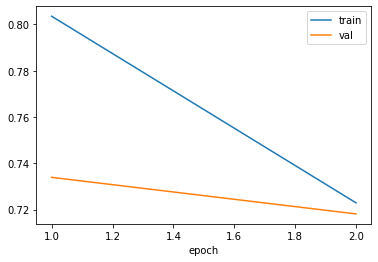

In [52]:
ax = pd.DataFrame(history).drop(columns='total').plot(x='epoch')

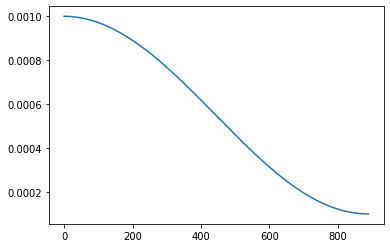

In [53]:
_ = plt.plot(lr_history[:4*iterations_per_epoch])

In [0]:

groud_truth, predictions = [], []

with torch.no_grad():
    for batch in batches(*datasets['val'], shuffle=False, bs=bs):
        x_batch, y_batch = [b.to(device) for b in batch]
        outputs = net(x_batch[:, 0], x_batch[:, 1])
        groud_truth.extend(y_batch.tolist())
        predictions.extend(outputs.tolist())

groud_truth = np.asarray(groud_truth).ravel()
predictions = np.asarray(predictions).ravel()

In [55]:
1 - sum(abs(groud_truth - np.round(predictions*2)/2))/(5* len(predictions))

0.873

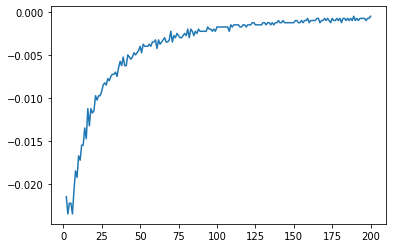

In [56]:
# В teg_rel у каждого фильма сортируем теги по убыванию релевантности
num_mov = len(set(tg_rel.movieId))
df_mov_tags = []
for i in range(0, num_mov):
    df_mov_tags.append(tg_rel.iloc[i*1128:(i+1)*1128].sort_values(by="relevance", ascending= 0))
tg_rel = pd.concat(df_mov_tags)
tg_rel = tg_rel.reset_index().drop("index", axis = 1)
# Ищем число тег, значимо характеризующие каждый фильм 
table_tags =np.array([tg_rel.iloc[0: 200].relevance.values])
for i in range(1, num_mov):
    table_tags = np.vstack((table_tags, np.array([tg_rel.iloc[i*1128:i*1128 + 200].relevance.values])))
table_tags = pd.DataFrame(table_tags)
medians = np.median(table_tags, axis = 0)
differ = [medians[i] - medians[i - 1] for i in range(1, len(medians))]
plt.plot(np.arange(2, 201), differ)
plt.show()

In [0]:
n = 100
X_train, X_valid, y_train, y_valid = train_test_split(ratings.iloc[:, 0:2], ratings["rating"], test_size=n/ratings.shape[0], random_state=RANDOM_STATE, shuffle = 1)
train = X_train
train["rating"] = np.array(y_train)

In [0]:
def K_nearest_neighbors(train_data, test_data, k, tg_rel = None):
    answers = []
    train_data_sort = train_data.sort_values(by = 'userId').reset_index().drop('index', axis = 1)
    # С какого по какой индекс данный пользователь присутствует в тренировочной выборке
    d_user_index = dict()
    # При каких индексах в train data  присутствует данный фильм
    d_movie_indexes = dict()
    for i in range(train_data_sort.shape[0]):
        cur_movie = train_data_sort.iloc[i, 1]
        if cur_movie in d_movie_indexes.keys():
            d_movie_indexes[cur_movie].append(i)
        else:
            d_movie_indexes[cur_movie] = [i]
    last = train_data_sort.iloc[0,0]
    beg = 0
    for i in range(train_data_sort.shape[0]):
        cur_user = train_data_sort.iloc[i, 0]
        if last != cur_user:
            d_user_index[last] = [beg, i] # последний элемент i не относится к данному юзеру
            beg = i
            last = cur_user
    d_user_index[last] = [beg, train_data_sort.shape[0]]
    # Для каждого тестового примера пытаемся предсказать его рейтинг
    for i in range(test_data.shape[0]):
        cur_us, cur_mov = test_data.iloc[i,:]
        # Cловарь с фильмами и их оценками у данного пользователя
        cur_user_movies ={train_data_sort.iloc[j,1]:train_data_sort.iloc[j,2]
                          for j in range(*d_user_index[cur_us])}
        # У данного фильма отбираем перые 50 самых релевантных тег 
        if isinstance(tg_rel, pd.DataFrame):
            cur_tags = set(tg_rel.loc[tg_rel.movieId== cur_mov,["tagId","relevance"]][:50].tagId.values)
            # Из фильмов, просмотренных данным пользователем, по "Jaccard similarity coefficient" ищем самый схожий фильм с данным по тегам
            max_sim_tag = 0
            Jaccard = []
            for i in cur_user_movies.keys():
                tag_mov = set(tg_rel.loc[tg_rel.movieId== i,["tagId","relevance"]][:50].tagId.values)
                inters = len(cur_tags& tag_mov)
                Jaccard.append([i, inters/(100 - inters)])
            suit_mov = max(Jaccard, key = lambda x:x[1])
            pos_ans = train_data.loc[(train_data.movieId== suit_mov[0]) & (train_data.userId==cur_us),"rating"].values[0]

            if suit_mov[1] >0.5:
                answers.append(pos_ans)
                continue
        # Находим пользователей, которые тоже посмотрели данный фильм
        users_of_mov = [train_data_sort.iloc[j,0] for j in d_movie_indexes[cur_mov]]
        d_us_sim = []
        # Для каждого пользователя, оценившего данный фильм, ищем близость с данным пользователем 
        #   по модифицированной Евклидовой мере
        iter_ = 0
        for j in users_of_mov:
            # Словарь с фильмами и их оценками у данного пользователя
            estim_user_mov={train_data_sort.iloc[k,1]:train_data_sort.iloc[k,2] for k in range(*d_user_index[j])}
            # Ищем близость только по фильмам, которые просмотрели 2 пользователя
            common_mov = set(cur_user_movies.keys())& set(estim_user_mov.keys())
            if len(common_mov)>=3:
                user_sim = 1/ (1 + (sum([(cur_user_movies[i]- estim_user_mov[i])**2 for i in common_mov])/(len(common_mov)))**(1/2))
                d_us_sim.append([d_movie_indexes[cur_mov][iter_], user_sim])
                iter_ +=1
        # Если соседей по заданным условиям меньше k
        if len(d_us_sim) < k:
            k = len(d_us_sim)
        # Считаем среднее арифметическое оценок k самых похожих пользователей с данным
        k_first_d_us_sim = np.array(sorted(d_us_sim, key= lambda x: x[1],reverse= True))[:k]
        answers.append(train_data_sort.iloc[k_first_d_us_sim[:, 0], 2].dot(k_first_d_us_sim[:,0])/sum(k_first_d_us_sim[:,0]))
    return answers

In [59]:
# Алгоритм k- ближайших соседей
start = time.time()
y_pred_without_tags = K_nearest_neighbors(train, X_valid, 5)
print("Время выполнения программы: ", time.time() - start)

Время выполнения программы:  166.18356585502625


In [60]:
1 - sum(abs(y_valid - np.round(np.array(y_pred_without_tags)*2, 0)/2))/(len(y_valid) * 5)

0.848

In [61]:
# Модифицированный алгоритм k- ближайших, с использованием датасета с тегами
start = time.time()
y_pred_with_tags = K_nearest_neighbors(train, X_valid, 5, tg_rel)
print("Время выполнения программы: ", time.time() - start)

Время выполнения программы:  809.908035993576


In [62]:
1 - sum(abs(y_valid - np.round(np.array(y_pred_with_tags)*2, 0)/2))/(len(y_valid) * 5)

0.862